In [1]:
import matplotlib.pyplot as plt, numpy as np, seaborn as sns, scipy.stats as stats, pandas as pd, os, glob
import ast
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## load df and check

In [101]:
subjs = ['adam', 'tori', 'erfan', 'amisha']

df = pd.DataFrame()
print('types: ')
for subj in subjs:
    f_name = glob.glob(f'../results/*{subj}*.csv')[0]
    df_subj = pd.read_csv(f_name)[:240]
    df = pd.concat([df, df_subj], ignore_index=True)
    print(f_name.split('order-')[1][0], end=', ')


types: 
A, C, B, B, 

## filtering df

In [126]:
# 1.
print(df['correct'].value_counts(normalize=False))
print(f'accuracy: {df["correct"].mean() * 100:.2f}%\n')
print(df['outcome'].value_counts(normalize=False))


# 2.
for col in ['positions']:
    if type(df[col][0]) == str:
        df[col] = df[col].apply(lambda x: ast.literal_eval(x)) # convert str to list

# 3. # MAE = dist between target & last position
df['MAE_unnormed'] = abs(df['target_pos'] - df['positions'].apply(lambda x: x[-1]))
df['MAE_normed'] = np.where(
    ((df['condition'] == 'pen_comp') & (df['valence'] == 'pen')) | ((df['condition'] == 'rew_comp') & (df['valence'] == 'rew')),
    df['MAE_unnormed']*2, 
    df['MAE_unnormed']
)
# 4.
df['dist'] = df['positions'].apply(lambda x: abs(x[-1] - x[0]))
df['avg_speed'] = df['dist'] / df['trials.submit_resp.rt']

# 5.
df['choice'] = df['outcome'].apply(lambda x: 1 if abs(x) == 2 else 0 if abs(x) == 1 else 0)
# df = df[df['choice'] != 0]
df = df.copy()


# 6. flip positions if shape_order was flipped or if sess_type in ['B', 'D']
df['final_pos'] = df['positions'].apply(lambda x: x[-1]).copy()

print(f'\n{(df["shape_order"] == "flat_curv").sum()}, {(df["sess_type"].isin(["B", "D"])).sum()}')
df['final_pos'] = np.where(
    df['shape_order'] == 'flat_curv', -df['final_pos'], df['final_pos']
)
df['final_pos'] = np.where(
    df['sess_type'].isin(['B', 'D']), -df['final_pos'], df['final_pos']
)

# 7.
# filtering out easy trials
hard_thresh = .05
df_hard = df[df['target_pos'] - df['div_pos'] <= hard_thresh].copy()
print(f'\n% trials with |target-divider| <= {hard_thresh}: {len(df_hard)/len(df)}')

correct
1.0    750
0.0    210
Name: count, dtype: int64
accuracy: 78.12%

outcome
 1.0    383
 2.0    294
-1.0     96
 3.0     73
-2.0     55
 0.0     37
-3.0     22
Name: count, dtype: int64

480, 480

% trials with |target-divider| <= 0.05: 0.5666666666666667


## 1. analyses by valence and compression

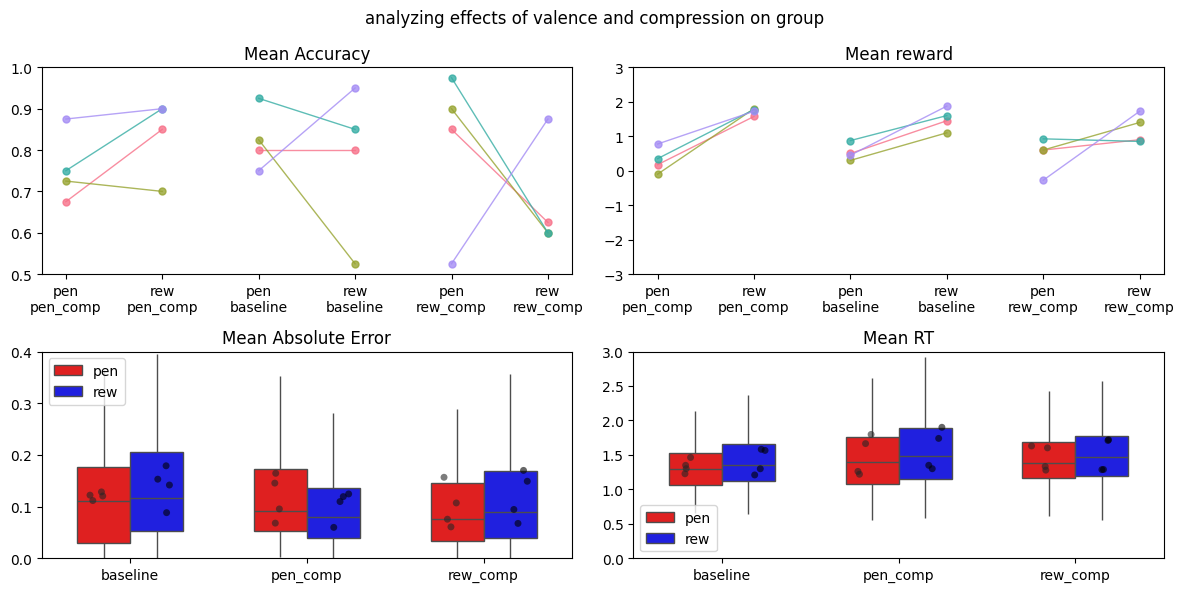

In [66]:
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()
fig.suptitle('analyzing effects of valence and compression on group')
order, hue_order, palette = df.condition.unique(), ['pen', 'rew'], {'pen': 'red', 'rew': 'blue'}

# subject-level means
group_df = df.groupby(['subj', 'condition', 'valence'])[['correct', 'outcome', 'MAE_unnormed', 'trials.submit_resp.rt']].mean().reset_index()

# change to categorical type to be able to sort vars to make plotting easier
group_df['valence'] = pd.Categorical(group_df['valence'], categories=['pen', 'rew'], ordered=True)
group_df['condition'] = pd.Categorical(group_df['condition'], categories=['pen_comp', 'baseline', 'rew_comp'], ordered=True)
group_df = group_df.sort_values(['subj', 'condition', 'valence'])

# x-axis labels: one per condition-valence combo
group_df['x_label'] = group_df['valence'].astype(str) + '-' + group_df['condition'].astype(str)
x_labels = group_df['x_label'].unique()
xticklabels = [f'{x.split("-")[0]}\n{x.split("-")[1]}' for x in x_labels]

# color per subject
subj_palette = dict(zip(group_df['subj'].unique(), sns.color_palette('husl', n_colors=group_df['subj'].nunique())))


# 1. accuracy
ax = axes[0]

for subj, subj_df in group_df.groupby('subj'):
    subj_df = subj_df.sort_values(['condition', 'valence'])
    for cond, cond_df in subj_df.groupby('condition'):
        x, y = cond_df['x_label'], cond_df['correct'].values
        if len(y) == 2:
            ax.plot(x, y, marker='o', color=subj_palette[subj], lw=1, markersize=5, alpha=0.8)

ax.set_xticks(x_labels)
ax.set_xticklabels(xticklabels)
ax.set_ylim(.5, 1)
ax.set_title('Mean Accuracy')


# 2. reward
ax = axes[1]
# plot lines within each condition
for subj, subj_df in group_df.groupby('subj'):

    for cond, cond_df in subj_df.groupby('condition'):
        x, y = cond_df['x_label'],  cond_df['outcome'].values
        ax.plot(x, y, marker='o', color=subj_palette[subj], lw=1, markersize=5, alpha=0.8)

ax.set_xticks(x_labels)
ax.set_xticklabels(xticklabels)
ax.set_ylim(-3, 3)
ax.set_title('Mean reward')


# 3. MAE
ax = axes[2]
sns.boxplot(data=df, x='condition', y='MAE_unnormed', hue='valence',
            order = order, hue_order = hue_order, palette = palette, showcaps=False, fliersize=0, width=0.6, ax=ax)

sns.stripplot(data=group_df, x='condition', y='MAE_unnormed', hue='valence', 
              order = order, hue_order = hue_order, color = 'black', dodge=True, alpha=0.6, jitter=True, legend=False, ax=ax)

ax.set_ylim(0, .4)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean Absolute Error')
# SOMETHING IS OFF HERE WITH THE LOGIC; SHOULDNT NORMALIZING ON THE EXPANDED SIDE BE DEPENDENT ON SAMPLING POSITION?
# AM I BEING TOO CONSRVATIVE WITH THE NORMALIZATION = .4?
ax.legend()


# 4. RT
ax = axes[3]
sns.boxplot(data=df, x='condition', y='trials.submit_resp.rt', hue='valence',
            order = order, hue_order = hue_order, palette = palette, showcaps=False, fliersize=0, width=0.6, ax=ax)

sns.stripplot(data=group_df, x='condition', y='trials.submit_resp.rt', hue='valence',
              order = order, hue_order = hue_order, color = 'black', dodge=True, alpha=0.6, jitter=True, legend=False, ax=ax)

ax.set_ylim(0, 3)
ax.set_ylabel('')
ax.set_xlabel('')
ax.set_title('Mean RT')
ax.legend()


plt.tight_layout()
plt.show()


## 2. analyses by perceptual space

/tmp/ipykernel_3258950/756633801.py:56: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(percept_labels)


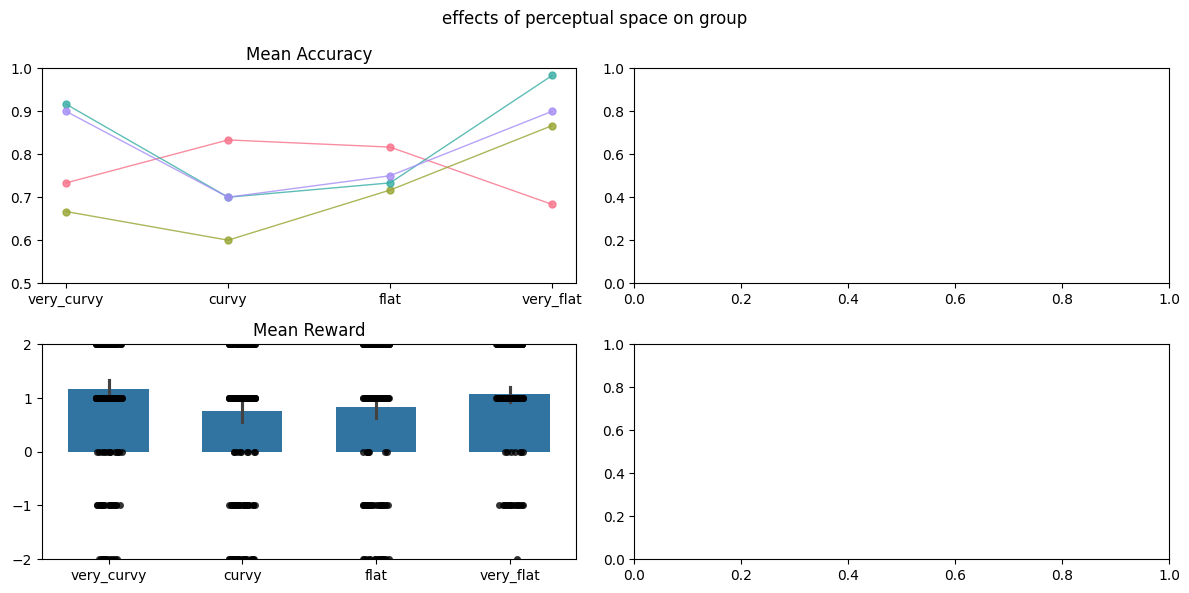

In [71]:
# create new col based on stim pos, called percept_space
conditions = [
    (-0.4 < df['stim_pos']) & (df['stim_pos'] < -0.2),
    (-0.2 < df['stim_pos']) & (df['stim_pos'] < 0),
    (0 < df['stim_pos']) & (df['stim_pos'] < 0.2),
    (0.2 < df['stim_pos']) & (df['stim_pos'] < 0.4)
]
percept_labels = ['very_curvy', 'curvy', 'flat', 'very_flat']
df['percept_space'] = np.select(conditions, percept_labels, default='other')
df['percept_space'] = pd.Categorical(df['percept_space'], categories=percept_labels, ordered=True)

# group_df based on vars of interest
# probably need to flip perceptual axis for salma and some other pilots
group_df = df.groupby(['subj', 'percept_space'])[['correct', 'MAE_unnormed', 'outcome', 'trials.submit_resp.rt']].mean().reset_index()
group_df = group_df.sort_values(['subj', 'percept_space'])
group_df

fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()
fig.suptitle('effects of perceptual space on group')

# 1. accuracy
ax = axes[0]

for subj, subj_df in group_df.groupby('subj'):
    # subj_df = subj_df.sort_values(['condition', 'valence'])

    x, y = subj_df['percept_space'], subj_df['correct'].values
    ax.plot(x, y, marker='o', color=subj_palette[subj], lw=1, markersize=5, alpha=0.8)

ax.set_ylim(.5, 1)
ax.set_title('Mean Accuracy')


# # 2. MAE
# ax = axes[1]
# sns.boxplot(data=df, x='percept_space', y='MAE_normed', showcaps=False, fliersize=0, width=0.6, ax=ax)
# sns.stripplot(data=group_df, x='percept_space', y='MAE_unnormed', color='black', dodge=True, alpha=0.6, jitter=True, legend=False, ax=ax)

# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.set_ylim(0, .6)
# ax.axhline(y=.4, color='black', linestyle='--', label = 'max error on correct side')
# ax.set_title('Mean Absolute Error (normed)')
# ax.set_xticklabels(percept_labels)

# 3. reward
ax = axes[2]
sns.barplot(data=df, x='percept_space', y='outcome', width=0.6, hue_order=hue_order, ax=ax)
sns.stripplot(data=df, x='percept_space', y='outcome', color='black', dodge=True, alpha=0.8, jitter=True, legend=False, ax=ax)

ax.set_ylabel('')
ax.set_xlabel('')
ax.set_ylim(-2, 2)
ax.set_title('Mean Reward')
ax.set_xticklabels(percept_labels)

# # 4. RT
# ax = axes[3]
# sns.boxplot(data=df, x='percept_space', y='trials.submit_resp.rt', showcaps=False, fliersize=0, width=0.6, ax=ax)
# sns.stripplot(data=group_df, x='percept_space', y='trials.submit_resp.rt', color='black', dodge=True, alpha=0.6, jitter=True, legend=True, ax=ax)

# ax.set_ylabel('')
# ax.set_xlabel('')
# ax.set_title('Mean RT')
# ax.set_xticklabels(percept_labels)

plt.tight_layout()
plt.show()



## 3. choice distribution

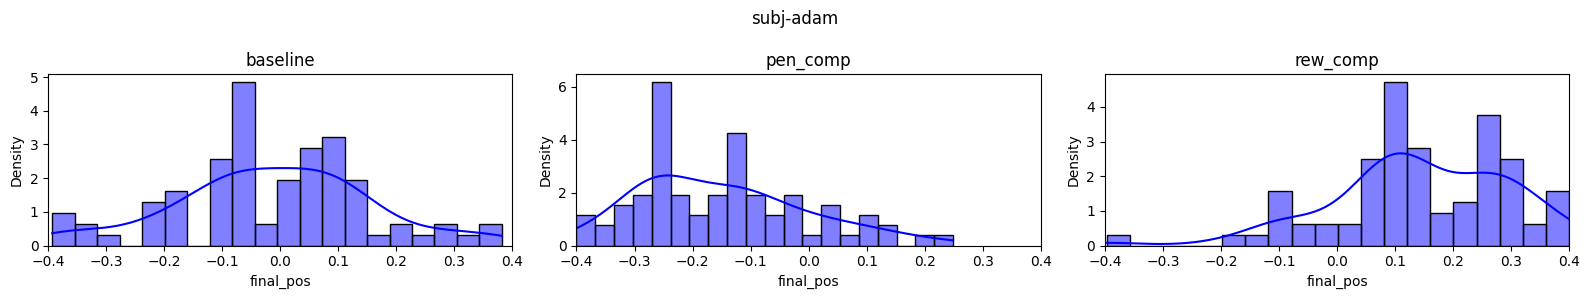

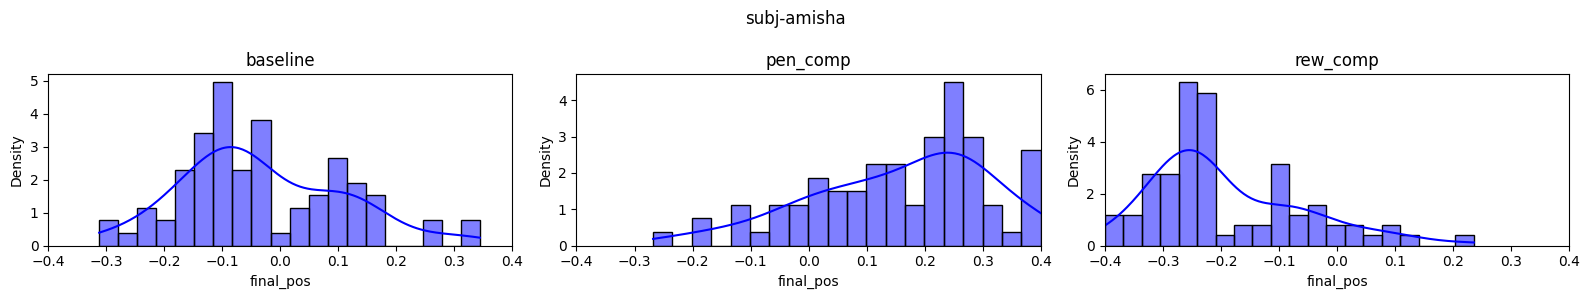

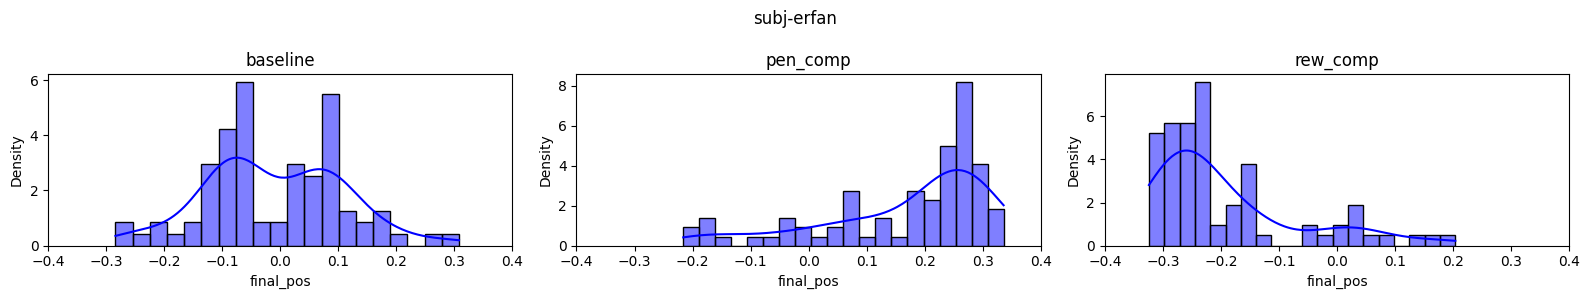

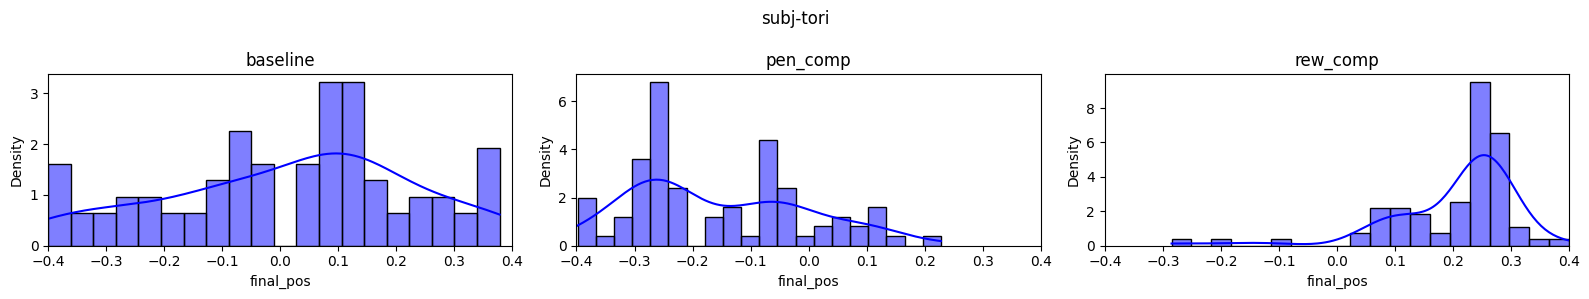

In [127]:
df_check_flip = df.copy()
df_check_flip['final_pos_orig'] = df_check_flip['positions'].apply(lambda x: x[-1])
df_check_flip = df_check_flip[['shape_order', 'sess_type', 'final_pos_orig', 'final_pos']]
df_check_flip.to_csv('../results/df_check_flip.csv', index=False)

for df_subj in df.groupby('subj'):
    
    fig, axs = plt.subplots(1, 3, figsize=(16, 3))
    axs, ax_i = axs.flatten(), 0
    fig.suptitle(f'subj-{df_subj[0]}')

    for df_cond in df_subj[1].groupby('condition'):
 
        sns.histplot(df_cond[1], x='final_pos', kde=True, bins=20, color='blue', ax=axs[ax_i], stat='density')
        axs[ax_i].set_title(f'{df_cond[0]}')
        axs[ax_i].set_xlim(-.4, .4)
        ax_i += 1

        plt.tight_layout()

plt.show()

## psychometric curves

In [78]:
from scipy.optimize import curve_fit

# Define sigmoid function
def sigmoid(x, x0, k):
    return 1 / (1 + np.exp(-k * (x - x0)))

# Convert choice to numeric (1 for risky, 0 for safe)
df_choice['choice_numeric'] = df_choice['choice'].map({'risky': 1, 'safe': 0})

# Initialize plot
plt.figure(figsize=(8, 6))

# Get unique subjects
subjects = df_choice['subj'].unique()

# Define color palette for subjects
palette = sns.color_palette("husl", len(subjects))

# Loop through each subject
for i, subj in enumerate(subjects):
    # Compute mean risky choice probability at each stim_pos for the subject
    grouped = df_choice[df_choice['subj'] == subj].groupby('stim_pos')['choice'].mean().reset_index()

    # Fit sigmoid function
    popt, _ = curve_fit(sigmoid, grouped['stim_pos'], grouped['choice'])
    
    # Generate smooth x values for curve
    x_vals = np.linspace(grouped['stim_pos'].min(), grouped['stim_pos'].max(), 100)
    y_vals = sigmoid(x_vals, *popt)

    # Plot fitted sigmoid curve
    plt.plot(x_vals, y_vals, color=palette[i], linestyle='-', label=f'Subj {subj}')

    # Scatter plot for observed probabilities
    sns.scatterplot(data=grouped, x='stim_pos', y='choice', color=palette[i], edgecolor='black')

# Labels and legend
plt.xlabel('Stimulus Position')
plt.ylabel('P(Risky Choice)')
plt.title('Psychometric Curves by Subject')
plt.legend()
plt.show()


NameError: name 'df_choice' is not defined